In [21]:
import torch
torch.__version__
from torch.nn import Linear


In [22]:

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html


In [23]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphNorm
from torch_geometric.datasets import Planetoid

# Load dataset

In [25]:
cora = Planetoid(root="./", name="Cora", split="public")
cora_dataset = cora[0]
cora_dataset

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [26]:
# Print size of train, validation, and test set
print(cora_dataset.train_mask.sum())
print(cora_dataset.val_mask.sum())
print(cora_dataset.test_mask.sum())

tensor(140)
tensor(500)
tensor(1000)


# Define Hyperparameters

In [27]:
args = {
    "learning_rate": 0.1,
    "num_epochs": 100,
    "hidden_size": 40,
    "experiment description": "Two-hop GCN Network, hidden size 40, SGD optimizer + momentum=0.9, learning rate 1e-1. Dropout with probability 0.5 before GCN layers, Graph Norm after GCN layer."
}

# Define Network and Optimizer

In [28]:
class GCN(torch.nn.Module):
    def __init__(self, input_features, hidden_size, num_classes, training=True):
        super().__init__()
        self.conv1 = GCNConv(input_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)

        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.norm1 = GraphNorm(hidden_size)
        self.norm2 = GraphNorm(hidden_size)

        self.lin1 = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.drop1(x)
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = self.act1(x)
        
        x = self.drop2(x)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = self.act2(x)
        
        x = self.lin1(x)
        return F.log_softmax(x, dim=1)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(cora_dataset.num_node_features, hidden_size=args["hidden_size"], num_classes=cora.num_classes).to(device)

cora_dataset = cora_dataset.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"], weight_decay=5e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=args["learning_rate"], momentum=0.9, weight_decay=5e-4)

In [30]:
print(model)

GCN(
  (conv1): GCNConv(1433, 40)
  (conv2): GCNConv(40, 40)
  (drop1): Dropout(p=0.5, inplace=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (act1): ReLU()
  (act2): ReLU()
  (norm1): GraphNorm(40)
  (norm2): GraphNorm(40)
  (lin1): Linear(in_features=40, out_features=7, bias=True)
)


# Visualization

In [31]:
def plot_loss_curves(train_losses, val_losses):
    assert len(train_losses) == len(val_losses), "Inconsistent plotting sizes."
    
    time = list(range(args["num_epochs"]))
    visual_df = pd.DataFrame({
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Epoch": time
    })

    sns.lineplot(x='Epoch', y='Loss Value', hue='Dataset Split', data=pd.melt(visual_df, ['Epoch'], value_name="Loss Value", var_name="Dataset Split"))
    plt.title("Loss Curves")
    plt.show()

In [32]:
def plot_accuracy_curves(train_acc, val_acc):
    assert len(train_acc) == len(val_acc), "Inconsistent plotting sizes."
    
    time = list(range(args["num_epochs"]))
    visual_df = pd.DataFrame({
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Epoch": time
    })

    sns.lineplot(x='Epoch', y='Accuracy', hue='Dataset Split', data=pd.melt(visual_df, ['Epoch'], value_name="Accuracy", var_name="Dataset Split"))
    plt.title("Accuracy Curves")
    plt.show()

# Training and Evaluation

In [33]:
def train(model, cora_dataset):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(args["num_epochs"]):
        if epoch % 20 == 0:
            print("Epoch {} starting...".format(epoch))
        
        model.train()
        optimizer.zero_grad()

        out = model(cora_dataset)  # Pass entire graph through model at once - batch gradient descent
        loss = F.nll_loss(out[cora_dataset.train_mask], cora_dataset.y[cora_dataset.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        correct = (pred[cora_dataset.train_mask] == cora_dataset.y[cora_dataset.train_mask]).sum()
        train_acc = int(correct) / int(cora_dataset.train_mask.sum())

        train_losses.append(loss.item())
        train_accuracies.append(train_acc)

        # Validate once per epoch
        val_loss, val_acc = validation(model, cora_dataset)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_acc)
    
    # Assert that sizes are all the same
    assert len(train_losses) == len(val_losses) == len(train_accuracies) == len(val_accuracies), "Metric list sizes are inconsistent."
    plot_loss_curves(train_losses, val_losses)
    plot_accuracy_curves(train_accuracies, val_accuracies)


In [34]:
def validation(model, cora_dataset):
    model.eval()
    out = model(cora_dataset)
    pred = out.argmax(dim=1)
    
    val_loss = F.nll_loss(out[cora_dataset.val_mask], cora_dataset.y[cora_dataset.val_mask])
    correct = (pred[cora_dataset.val_mask] == cora_dataset.y[cora_dataset.val_mask]).sum()
    val_acc = int(correct) / int(cora_dataset.val_mask.sum())
    
    return val_loss, val_acc


In [35]:
def test(model, cora_dataset):
    model.eval()
    pred = model(cora_dataset).argmax(dim=1)
    correct = (pred[cora_dataset.test_mask] == cora_dataset.y[cora_dataset.test_mask]).sum()
    accuracy = int(correct) / int(cora_dataset.test_mask.sum())
    print(f'Test Set Accuracy: {accuracy:.4f}')
    return accuracy

# Driver Code

Epoch 0 starting...
Epoch 20 starting...
Epoch 40 starting...
Epoch 60 starting...
Epoch 80 starting...


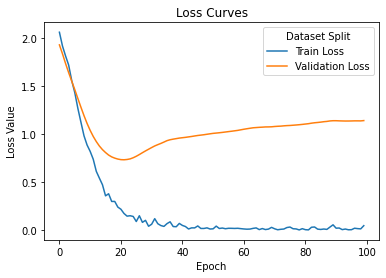

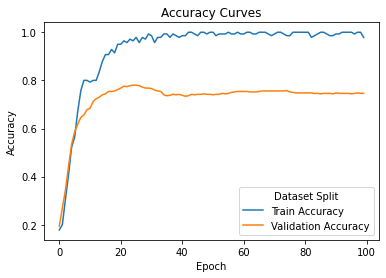

In [36]:
train(model, cora_dataset)

In [37]:
test_acc = test(model, cora_dataset)

# Save test accuracy so that we log it somewhere. Train and val accuracy are kept in the accuracy curves
args["test accuracy"] = test_acc

Test Set Accuracy: 0.7790


In [38]:
out = model(cora_dataset)

In [39]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#可视化
def visualize(out, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.title("GCN")
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    plt.savefig('./GCN.png',dpi=600)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


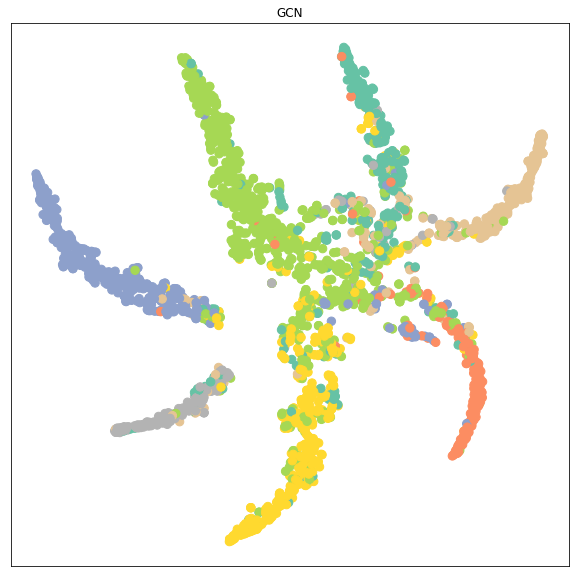

<Figure size 432x288 with 0 Axes>

In [40]:
visualize(out, color=cora_dataset.y.detach().cpu().numpy())